In [1]:
# Import packages
import seaborn as sns
import geopandas as gpd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load
from sklearn.metrics import r2_score
import shap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import PartialDependenceDisplay

C:\Users\Holger\micromamba\envs\agile2024\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_theme()

# Prepare RF training and test sets

In [3]:
# Read observation data
obs_data = gpd.read_file("agile2024_tn_median_obs_sites.gpkg")
display(obs_data)

,site_code,obs_id,obs_value,arable_prop,arable_prop_buff_100,arable_prop_buff_1000,arable_prop_buff_500,area,awc1_min,awc1_max,...,tri_mean,tri_std,twi_min,twi_max,twi_mean,twi_std,urban_prop,water_prop,wetland_prop,geometry
0,SJA8127000,161,0.992,0.086,0.175,0.092,0.124,1.512569e+08,0.178,0.212,...,0.119,0.176,2.206,14.725,9.732,1.706,0.006,0.005,0.129,POINT (696315.000 6546937.000)
1,SJA9900000,200,1.302,0.182,0.170,0.178,0.190,8.071414e+08,0.173,0.215,...,0.100,0.191,1.725,15.356,9.827,1.375,0.026,0.008,0.087,POINT (669868.000 6591973.000)
2,SJA3956000,90,6.833,0.536,0.340,0.520,0.464,4.229881e+08,0.169,0.207,...,0.112,0.150,1.869,15.563,9.910,1.513,0.049,0.003,0.006,POINT (636008.000 6603086.000)
3,SJA1934000,40,1.642,0.243,0.134,0.172,0.156,2.132077e+08,0.173,0.211,...,0.109,0.183,1.842,14.976,9.745,1.348,0.056,0.004,0.014,POINT (700294.000 6592517.000)
4,SJA7837000,157,2.783,0.293,0.321,0.330,0.352,3.100426e+08,0.173,0.208,...,0.111,0.151,1.859,15.576,9.724,1.397,0.111,0.007,0.058,POINT (520653.000 6588232.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,SJB3503000,238,8.225,0.537,0.316,0.523,0.453,1.122941e+08,0.174,0.205,...,0.099,0.111,2.279,15.563,10.033,1.392,0.028,0.002,0.014,POINT (633230.000 6585334.000)
235,SJA3731000,84,1.725,0.200,0.065,0.122,0.085,6.085978e+07,0.175,0.206,...,0.124,0.223,1.842,14.565,9.663,1.395,0.072,0.003,0.009,POINT (698754.000 6586118.000)
236,SJA0813000,17,3.250,0.452,0.223,0.499,0.475,4.023375e+07,0.174,0.207,...,0.207,0.272,2.373,16.631,9.019,2.097,0.033,0.007,0.014,POINT (619933.000 6581023.000)
237,SJA8884000,175,3.300,0.242,0.176,0.232,0.225,1.930663e+09,0.164,0.218,...,0.105,0.145,1.464,15.329,9.728,1.468,0.025,0.010,0.106,POINT (551221.000 6591443.000)


In [4]:
obs_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 86 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   site_code                      239 non-null    object  
 1   obs_id                         239 non-null    int64   
 2   obs_value                      239 non-null    float64 
 3   arable_prop                    239 non-null    float64 
 4   arable_prop_buff_100           239 non-null    float64 
 5   arable_prop_buff_1000          239 non-null    float64 
 6   arable_prop_buff_500           239 non-null    float64 
 7   area                           239 non-null    float64 
 8   awc1_min                       239 non-null    float64 
 9   awc1_max                       239 non-null    float64 
 10  awc1_mean                      239 non-null    float64 
 11  awc1_std                       239 non-null    float64 
 12  bd1_min                     

In [5]:
# Create interactive plot of observation values
obs_data.explore(
    column="obs_value",
    cmap="YlOrRd",
    tooltip=["site_code", "obs_value"],
    marker_kwds={"radius": 4}, 
    style_kwds={"color": "black", "weight": 1, "fillOpacity": 0.9}
)

In [6]:
# Extract features and target
X = obs_data.iloc[:, 3:-1]
y = obs_data["obs_value"]

In [7]:
# Split the data into training and test sets
test_size = 0.3
random_state = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [8]:
X_train

,arable_prop,arable_prop_buff_100,arable_prop_buff_1000,arable_prop_buff_500,area,awc1_min,awc1_max,awc1_mean,awc1_std,bd1_min,...,tri_max,tri_mean,tri_std,twi_min,twi_max,twi_mean,twi_std,urban_prop,water_prop,wetland_prop
181,0.304,0.180,0.298,0.258,440956775.0,0.179,0.213,0.198,0.005,0.391,...,3.635,0.098,0.134,1.998,15.329,9.927,1.507,0.016,0.005,0.135
59,0.531,0.287,0.489,0.435,61123250.0,0.168,0.205,0.188,0.006,0.402,...,2.723,0.146,0.128,2.238,15.410,9.085,1.423,0.032,0.002,0.003
167,0.060,0.031,0.061,0.055,99466200.0,0.172,0.205,0.192,0.004,0.406,...,5.686,0.123,0.212,2.024,14.149,9.380,1.506,0.037,0.006,0.071
220,0.475,0.271,0.573,0.497,29300575.0,0.174,0.202,0.190,0.004,0.373,...,2.757,0.134,0.201,2.321,14.517,9.690,1.718,0.025,0.004,0.096
138,0.042,0.013,0.046,0.038,53754425.0,0.145,0.207,0.186,0.004,0.403,...,2.344,0.205,0.219,2.730,14.358,8.422,1.816,0.006,0.010,0.079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,0.152,0.065,0.133,0.131,77609375.0,0.000,0.205,0.192,0.004,0.410,...,3.064,0.221,0.221,2.512,15.102,8.506,2.225,0.017,0.034,0.107
72,0.266,0.188,0.281,0.267,591372600.0,0.000,0.213,0.190,0.005,0.000,...,5.150,0.227,0.240,1.639,15.481,8.537,2.083,0.041,0.031,0.032
140,0.201,0.137,0.209,0.205,469818575.0,0.163,0.214,0.189,0.005,0.373,...,4.707,0.210,0.250,1.908,16.318,8.770,2.037,0.016,0.006,0.051
235,0.200,0.065,0.122,0.085,60859775.0,0.175,0.206,0.191,0.005,0.412,...,4.166,0.124,0.223,1.842,14.565,9.663,1.395,0.072,0.003,0.009


In [9]:
y_train

181    4.5375
59     3.3750
167    2.5000
220    7.5695
138    0.7550
        ...  
137    1.1080
72     0.9420
140    0.8780
235    1.7250
37     4.3250
Name: obs_value, Length: 167, dtype: float64

# Hyperparameter tuning

In [10]:
# Number of trees in random forest
n_estimators = list(np.linspace(start=10, stop=100, num=10, dtype=int))

# Number of features to consider at every split
max_features = [1, "sqrt", "log2"]

# Maximum number of levels in tree
max_depth = list(np.linspace(start=10, stop=100, num=10, dtype=int))
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create dictionary from parameters
param_distributions = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap
}

In [11]:
%%time

# Perform search for hyperparameters
estimator = RandomForestRegressor()
rf_random = RandomizedSearchCV(
    estimator=estimator, param_distributions=param_distributions, n_iter=100, verbose=2, random_state=random_state,
    n_jobs=-1
)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 2.78 s
Wall time: 31.6 s


RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': [1, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=1, verbose=2)

In [12]:
# Get best parameters
params = rf_random.best_params_
params["bootstrap"] = True
params["oob_score"] = True

print(rf_random)
print(params)

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': [1, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=1, verbose=2)
{'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True, 'oob_score': True}


# Train model

In [13]:
# RF regressor
regressor = RandomForestRegressor()

In [14]:
# Set hyperparameters
regressor.set_params(**params)

RandomForestRegressor(max_depth=90, max_features='sqrt', n_estimators=30,
                      oob_score=True)

In [15]:
# Fit model
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=90, max_features='sqrt', n_estimators=30,
                      oob_score=True)

In [16]:
# Calculate accuracy on training set
regressor.score(X_train, y_train)

0.9470177797180522

In [17]:
# Predict
Y_train_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)

In [18]:
# Calculate accuracy on test set
r2_score(y_test, Y_test_pred)

0.5620981849052227

# Calculate SHAP values

In [19]:
# Calculate SHAP values
explainer = shap.TreeExplainer(regressor)
shap_values = shap.TreeExplainer(regressor).shap_values(X_train)

In [20]:
shap_values

array([[-0.00969007, -0.02007813, -0.0779391 , ...,  0.07219874,
         0.02405564, -0.01716588],
       [ 0.22409908,  0.09279747,  0.25146375, ...,  0.01520569,
         0.15418863,  0.21639853],
       [-0.09879599, -0.02617834, -0.10566377, ...,  0.04459418,
         0.00867688,  0.00143501],
       ...,
       [-0.07466988, -0.01762514, -0.06652171, ...,  0.00371335,
        -0.0006924 , -0.01721733],
       [-0.0773175 , -0.02171907, -0.1508008 , ...,  0.03558439,
         0.03640026,  0.03255682],
       [ 0.24051929, -0.06551582,  0.45141466, ...,  0.01712556,
         0.10196378,  0.01035348]])

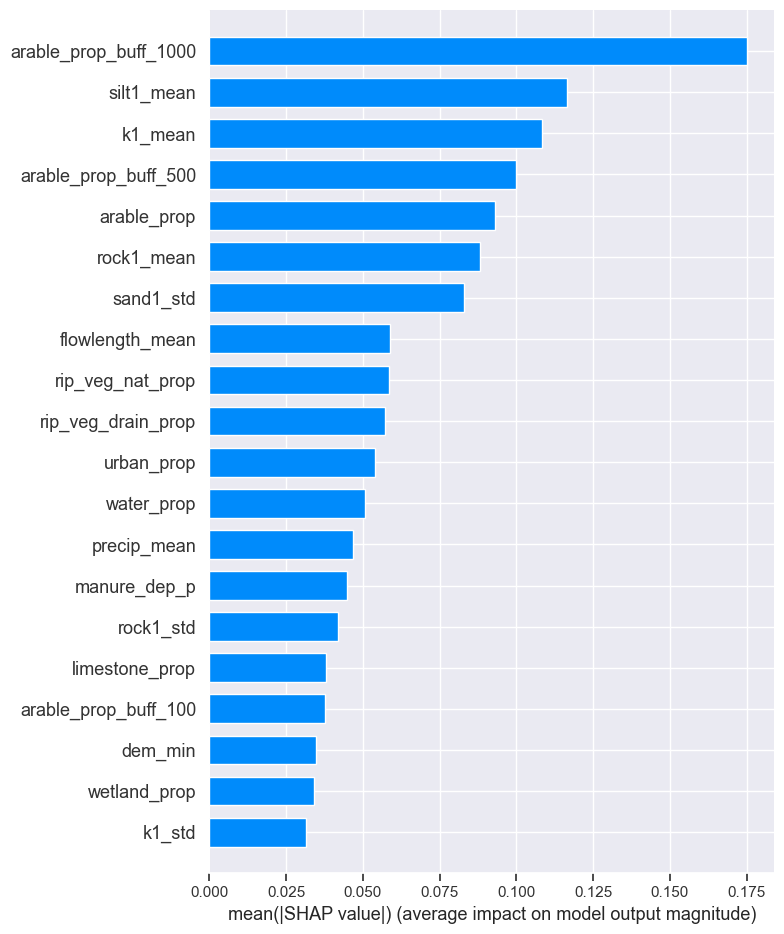

<Figure size 640x480 with 0 Axes>

In [21]:
# SHAP summary bar plot
shap.summary_plot(shap_values=shap_values, features=X_train, feature_names=X_train.columns, plot_type="bar")
plt.tight_layout()

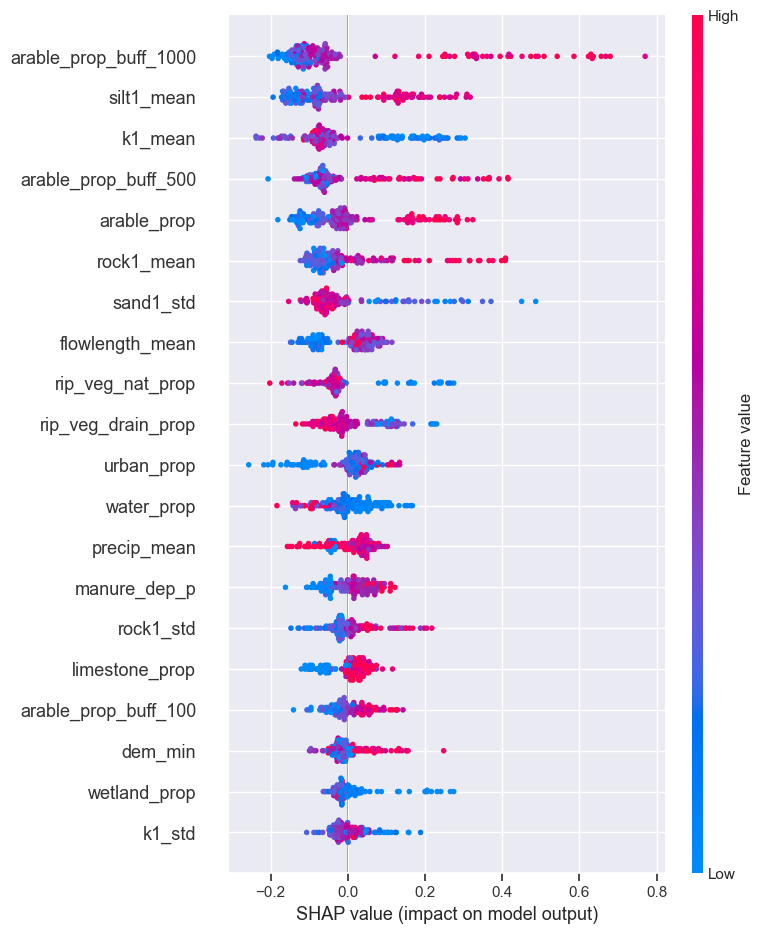

<Figure size 640x480 with 0 Axes>

In [22]:
# SHAP summary beeswarm plot
shap.summary_plot(shap_values=shap_values, features=X_train, feature_names=X_train.columns)
plt.tight_layout()

# Reduce number of features based on SHAP values

In [23]:
# Create DataFrame of absolute mean SHAP values
abs_mean_shap_df = pd.DataFrame(
    list(zip(X_test.columns, np.abs(shap_values).mean(0))), columns=["feature", "abs_mean_shap"]
)

In [24]:
# Sort based on absolute mean SHAP values
abs_mean_shap_df = abs_mean_shap_df.sort_values(by=["abs_mean_shap"], ascending=False).reset_index(drop=True)

In [25]:
abs_mean_shap_df

,feature,abs_mean_shap
0,arable_prop_buff_1000,0.175184
1,silt1_mean,0.116650
2,k1_mean,0.108409
3,arable_prop_buff_500,0.099809
4,arable_prop,0.092893
...,...,...
77,k1_max,0.000653
78,sand1_min,0.000624
79,flowlength_min,0.000000
80,rock1_min,0.000000


In [26]:
# List of most important features
n_features = 10
top_features = abs_mean_shap_df["feature"].head(n_features).to_list()
print(top_features)

['arable_prop_buff_1000', 'silt1_mean', 'k1_mean', 'arable_prop_buff_500', 'arable_prop', 'rock1_mean', 'sand1_std', 'flowlength_mean', 'rip_veg_nat_prop', 'rip_veg_drain_prop']


In [27]:
# Generate new training and test feature sets
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

# Train model on reduced data

In [28]:
%%time

# Perform search for hyperparameters
estimator = RandomForestRegressor()
rf_random = RandomizedSearchCV(
    estimator=estimator, param_distributions=param_distributions, n_iter=100, verbose=2, random_state=random_state,
    n_jobs=-1
)
rf_random.fit(X_train_reduced, y_train)

# Get best parameters
params = rf_random.best_params_
params["bootstrap"] = True
params["oob_score"] = True

print(rf_random)
print(params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': [1, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=1, verbose=2)
{'n_estimators': 80, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True, 'oob_score': True}
CPU times: total: 2.62 s
Wall time: 20.2 s


In [29]:
# RF regressor
regressor_reduced = RandomForestRegressor()

# Set hyperparameters
regressor_reduced.set_params(**params)

# Fit model
regressor_reduced.fit(X_train_reduced, y_train)

RandomForestRegressor(max_depth=10, max_features='log2', min_samples_leaf=4,
                      min_samples_split=5, n_estimators=80, oob_score=True)

In [30]:
# Calculate accuracy on training set
regressor_reduced.score(X_train_reduced, y_train)

0.8364512531181347

In [31]:
# Predict
Y_train_pred_reduced = regressor_reduced.predict(X_train_reduced)
Y_test_pred_reduced = regressor_reduced.predict(X_test_reduced)

In [32]:
# Calculate accuracy on test set
r2_score(y_test, Y_test_pred_reduced)

0.5616109692391531

# SHAP analysis of the new model

In [33]:
# Calculate SHAP values
explainer_reduced = shap.TreeExplainer(regressor_reduced)
shap_values_reduced = shap.TreeExplainer(regressor_reduced).shap_values(X_train_reduced)

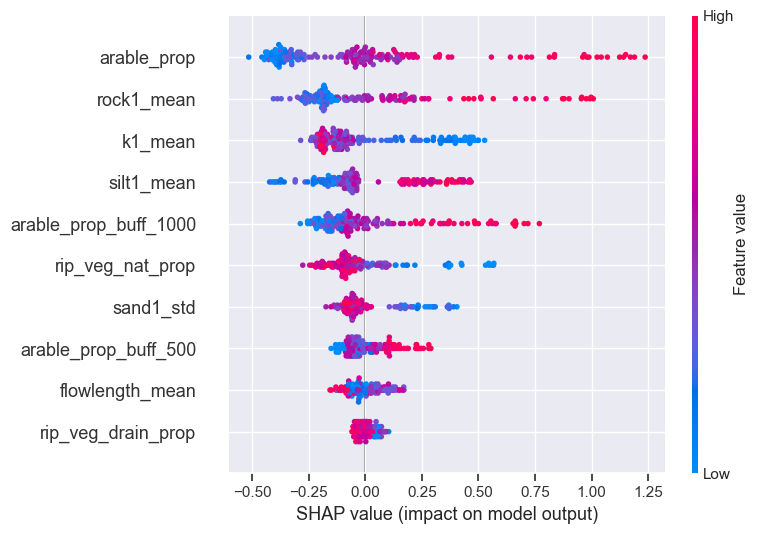

<Figure size 640x480 with 0 Axes>

In [34]:
# SHAP summary beeswarm plot
shap.summary_plot(shap_values=shap_values_reduced, features=X_train_reduced, feature_names=X_train_reduced.columns)
plt.tight_layout()

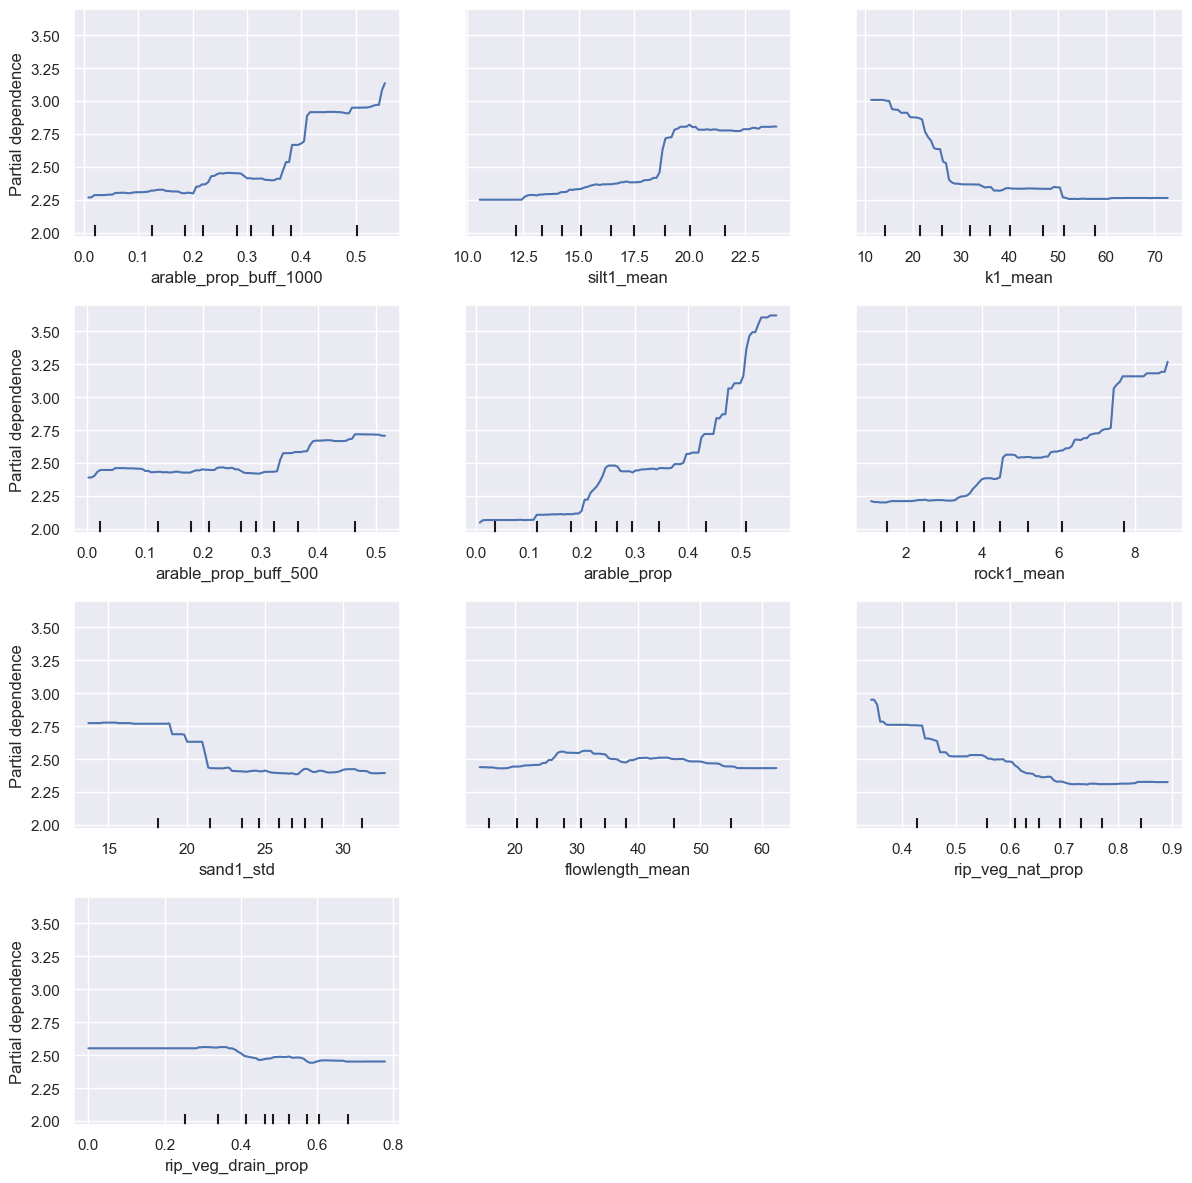

In [35]:
# Create partial dependence plot
fig, ax = plt.subplots(figsize=(12, 12))
disp = PartialDependenceDisplay.from_estimator(regressor_reduced, X_train_reduced, X_train_reduced.columns, ax=ax)
fig.subplots_adjust(hspace=0.3)
fig.tight_layout()